## Dependencies

In [2]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd

## De-serializing data

In [3]:
telecom = pickle.load(open('serialized files/telecom.pkl', 'rb'))
telecom

,user_id,Channel,TotalTransactionAmount,Tx_Count,DaysSinceLastTrans,reseller_id,superdealer_id,Product_ServiceProvider,Product_Type,Product_Category
1,1287,1.0,1635552,131,30,0.0,18.0,MTN,Airtime,Telco
3,1119,2.0,12200,13,30,0.0,447.0,Airtel,Data,Telco
5,1119,1.0,53400,106,30,0.0,447.0,MTN,Airtime,Telco
7,919,1.0,75100,319,30,0.0,447.0,Glo,Airtime,Telco
8,919,1.0,97350,265,30,0.0,447.0,MTN,Airtime,Telco
...,...,...,...,...,...,...,...,...,...,...
2617,2674,2.0,850,3,36,2557.0,501.0,Airtel,Data,Telco
2618,2674,1.0,200,1,42,2557.0,501.0,Glo,Airtime,Telco
2623,2630,1.0,100,1,30,0.0,501.0,Glo,Airtime,Telco
2630,2421,1.0,1400,4,32,1130.0,18.0,MTN,Airtime,Telco


## Preprocessing

In [23]:
telecom = telecom[['user_id', 'TotalTransactionAmount', 'Tx_Count', 'DaysSinceLastTrans']]
telecom

,user_id,TotalTransactionAmount,Tx_Count,DaysSinceLastTrans
1,1287,1635552,131,30
3,1119,12200,13,30
5,1119,53400,106,30
7,919,75100,319,30
8,919,97350,265,30
...,...,...,...,...
2617,2674,850,3,36
2618,2674,200,1,42
2623,2630,100,1,30
2630,2421,1400,4,32


In [24]:
telecom.describe()

,user_id,TotalTransactionAmount,Tx_Count,DaysSinceLastTrans
count,2276.000000,2.276000e+03,2276.000000,2276.000000
mean,1308.309754,4.158323e+04,78.835237,110.127417
std,646.597187,5.324434e+05,1204.331862,66.906098
min,3.000000,1.000000e+00,1.000000,30.000000
25%,907.000000,2.000000e+02,1.000000,54.000000
50%,1176.000000,1.000000e+03,3.000000,103.000000
75%,1640.000000,3.757500e+03,8.000000,137.000000
max,2725.000000,2.086921e+07,46531.000000,605.000000


In [25]:
tele_customers = telecom.groupby(['user_id']).agg({
    'TotalTransactionAmount': 'sum',
    'Tx_Count': 'count',
    'DaysSinceLastTrans' : 'sum'
})

tele_customers.rename(columns={'TotalTransactionAmount': 'Amount',
                                 'Tx_Count': 'Freq',
                                'DaysSinceLastTrans': 'Re'}, inplace=True)
tele_customers

,Amount,Freq,Re
user_id,,,
3,100,1,351
14,51,1,231
18,9708,9,1941
19,100,1,605
32,7800,2,274
...,...,...,...
2682,10050,5,151
2684,1200,2,79
2690,1400,1,32


In [26]:
print(tele_customers.Re.skew())
print(tele_customers.Freq.skew())
print(tele_customers.Amount.skew())

2.9767677658865397
1.8685113100577722
21.762190634919907


### Converting Data to Gaussian Distribution

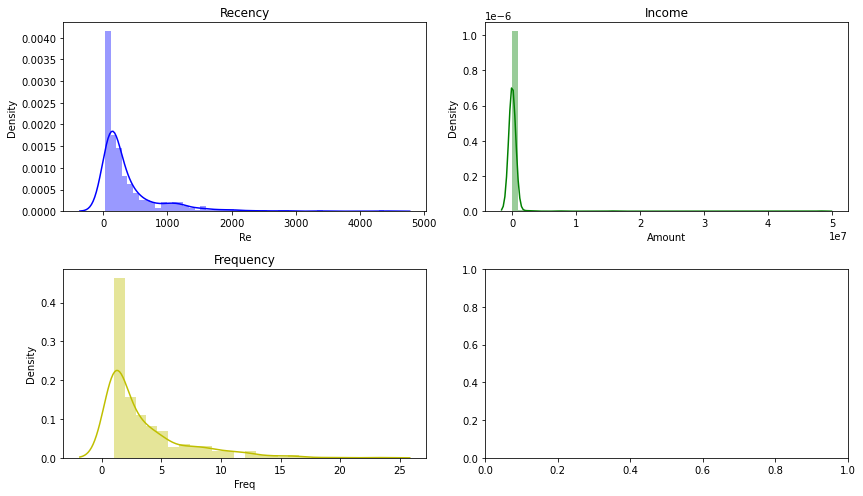

In [27]:
import warnings
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(2, 2, figsize=(12, 7))

fig = sns.distplot(tele_customers.Re, color='b', ax=ax[0, 0])
fig = sns.distplot(tele_customers.Amount, color='g', ax=ax[0, 1])
fig = sns.distplot(tele_customers.Freq, color='y', ax=ax[1, 0])
ax[0, 0].set_title('Recency')
ax[0, 1].set_title('Income')
ax[1, 0].set_title('Frequency')

plt.tight_layout()
plt.show()

#### BoxCox Transfromation

In [28]:
tele_customers['Amount'] = stats.boxcox(tele_customers['Amount'])[0]
tele_customers['Freq'] = stats.boxcox(tele_customers['Freq'])[0]
tele_customers['Re'] = stats.boxcox(tele_customers['Re'])[0]
tele_customers

,Amount,Freq,Re
user_id,,,
3,3.854581,0.000000,3.145122
14,3.375360,0.000000,3.037377
18,6.510700,1.386471,3.488488
19,3.854581,0.000000,3.270065
32,6.404505,0.594086,3.082652
...,...,...,...
2682,6.527333,1.139448,2.916220
2684,5.416306,0.594086,2.706095
2690,5.503374,0.000000,2.352622


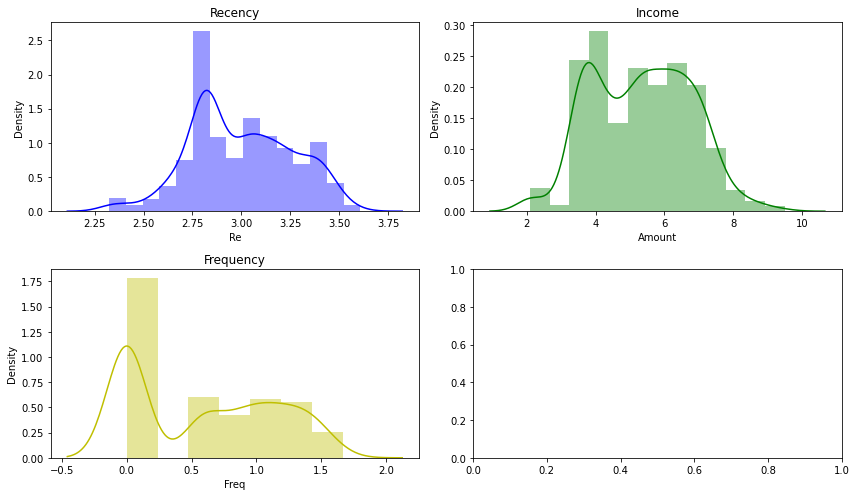

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(12, 7))

fig = sns.distplot(tele_customers.Re, color='b', ax=ax[0, 0])
fig = sns.distplot(tele_customers.Amount, color='g', ax=ax[0, 1])
fig = sns.distplot(tele_customers.Freq, color='y', ax=ax[1, 0])
ax[0, 0].set_title('Recency')
ax[0, 1].set_title('Income')
ax[1, 0].set_title('Frequency')

plt.tight_layout()
plt.show()

#### Normalization

In [31]:
scale = StandardScaler()
scale.fit(tele_customers)
telecom_normalized = scale.transform(tele_customers)

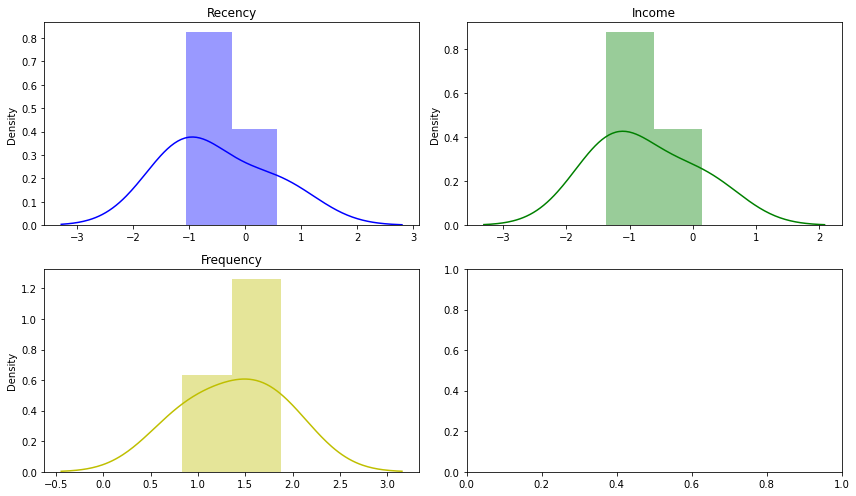

[-0.  0. -0.]
[1. 1. 1.]


In [32]:
fig, ax = plt.subplots(2, 2, figsize=(12, 7))

fig = sns.distplot(telecom_normalized[0], color='b', ax=ax[0, 0])
fig = sns.distplot(telecom_normalized[1], color='g', ax=ax[0, 1])
fig = sns.distplot(telecom_normalized[2], color='y', ax=ax[1, 0])
ax[0, 0].set_title('Recency')
ax[0, 1].set_title('Income')
ax[1, 0].set_title('Frequency')

plt.tight_layout()
plt.show()

print(telecom_normalized.mean(axis = 0).round(2))
print(telecom_normalized.std(axis = 0).round(2))

### Clustering

#### Hyperparameter Tuning using the Elbow Method

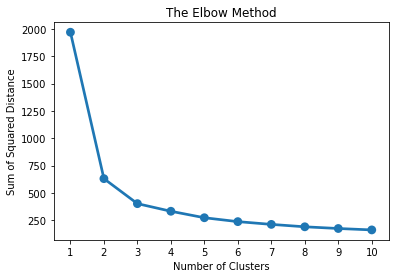

In [42]:
sse = {}

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(telecom_normalized)
    sse[k] = kmeans.inertia_
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distance')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [47]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(telecom_normalized)
model.labels_

array([1, 1, 2, 1, 0, 2, 2, 0, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 2, 2,
       2, 1, 2, 1, 0, 2, 2, 1, 2, 2, 0, 2, 2, 2, 2, 0, 2, 1, 2, 2, 1, 0,
       2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 1, 1, 1, 0, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 0, 0, 2, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 1, 2, 0, 0, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 0, 0,
       2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 1, 2, 2, 2, 2, 0,
       2, 0, 2, 0, 2, 0, 2, 2, 1, 0, 1, 1, 1, 2, 0, 0, 2, 1, 0, 0, 2, 0,
       2, 2, 1, 2, 1, 1, 2, 1, 2, 0, 0, 1, 2, 1, 2, 2, 0, 0, 2, 2, 0, 0,
       2, 1, 2, 2, 0, 2, 0, 1, 1, 2, 1, 2, 2, 2, 2, 2, 0, 1, 1, 1, 0, 1,
       0, 1, 2, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2,
       1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 0,
       0, 1, 0, 1, 2, 1, 0, 0, 1, 2, 0, 0, 1, 0, 0, 2, 1, 2, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 2,

#### Matching labels with each customer

In [48]:
tele_customers["Cluster"] = model.labels_
tele_customers.groupby('Cluster').agg({
    'Re':'mean',
    'Freq':'mean',
    'Amount':['mean', 'count']}).round(2)

df_normalized = pd.DataFrame(telecom_normalized, columns=['Re', 'Freq', 'Amount'])
df_normalized['Cust ID'] = tele_customers.index
df_normalized['Cluster'] = model.labels_
df_normalized

,Re,Freq,Amount,Cust ID,Cluster
0,-1.035397,-1.051969,0.564427,3,1
1,-1.371504,-1.051969,0.150927,14,1
2,0.827502,1.430700,1.882197,18,2
3,-1.035397,-1.051969,1.043934,19,1
4,0.753021,0.011825,0.324682,32,0
...,...,...,...,...,...
652,0.839167,0.988371,-0.314052,2682,0
653,0.059937,0.011825,-1.120469,2684,0
654,0.121003,-1.051969,-2.477027,2690,1
655,-0.524300,-1.051969,-2.328987,2694,1


#### Melting the Dataframe

In [49]:
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['Cust ID', 'Cluster'],
                      value_vars=['Re','Freq','Amount'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt

,Cust ID,Cluster,Attribute,Value
0,3,1,Re,-1.035397
1,14,1,Re,-1.371504
2,18,2,Re,0.827502
3,19,1,Re,-1.035397
4,32,0,Re,0.753021
...,...,...,...,...
1966,2682,0,Amount,-0.314052
1967,2684,0,Amount,-1.120469
1968,2690,1,Amount,-2.477027
1969,2694,1,Amount,-2.328987


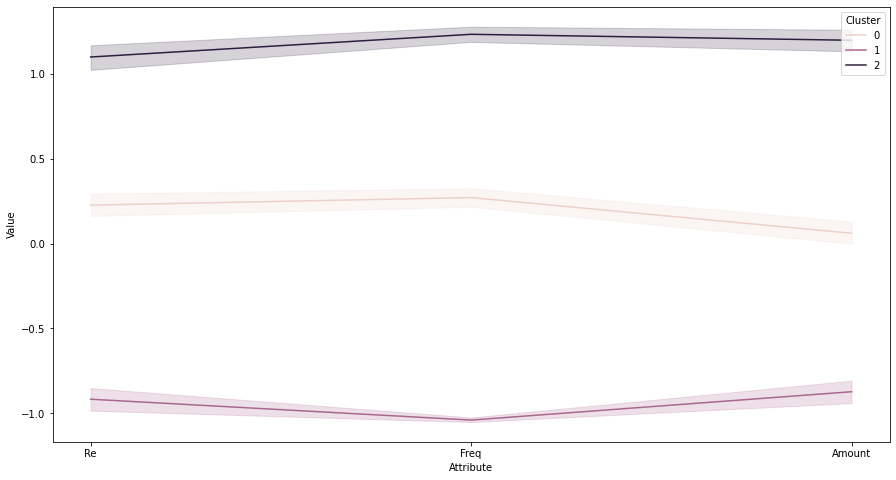

In [50]:
plt.figure(figsize=(15, 8))
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt)
plt.show()